# Analiza operacji konwolucji w PyTorch

**Autor:** Mateusz Łopaciński

**Data:** 18.10.2025

Ten notebook demonstruje podstawowe operacje konwolucji, testowanie filtrów na rzeczywistych obrazach oraz sprawdzenie wpływu parametrów na rozmiar wyjścia.

In [24]:
# Importowanie wymaganych bibliotek
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import cv2

print("Biblioteki zaimportowane pomyślnie!")
print(f"Wersja PyTorch: {torch.__version__}")
print(f"Wersja NumPy: {np.__version__}")
print(f"Wersja OpenCV: {cv2.__version__}")

Biblioteki zaimportowane pomyślnie!
Wersja PyTorch: 2.9.0
Wersja NumPy: 2.2.6
Wersja OpenCV: 4.12.0


## Ładowanie obrazu testowego

Załadowano obraz testowy z materiałów laboratoryjnych.


Obraz załadowany: (426, 640, 3)
Skala szarości: (426, 640)


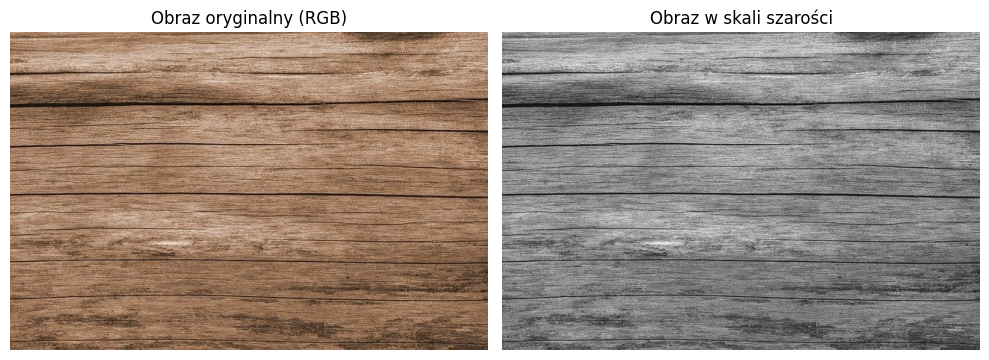

In [ ]:
# Ładowanie obrazu testowego
image_path = 'materials/Lab_01_im_filters/input-image-of-wood.jpg'
image_bgr = cv2.imread(image_path)

if image_bgr is None:
    print("Nie można załadować obrazu!")
else:
    # Konwersja BGR -> RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    # Konwersja do skali szarości
    image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    
    print(f"Obraz załadowany: {image_rgb.shape}")
    print(f"Skala szarości: {image_gray.shape}")
    
    # Wyświetlenie obrazu
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title('Obraz oryginalny (RGB)')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image_gray, cmap='gray')
    plt.title('Obraz w skali szarości')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Przygotowanie obrazu do konwolucji w PyTorch
# Konwersja do tensoru PyTorch
image_tensor = torch.from_numpy(image_gray).float().unsqueeze(0).unsqueeze(0) / 255.0
print(f"Tensor obrazu: {image_tensor.shape}")
print(f"Zakres wartości: [{image_tensor.min():.3f}, {image_tensor.max():.3f}]")

Tensor obrazu: torch.Size([1, 1, 426, 640])
Zakres wartości: [0.012, 0.957]


## Test różnych filtrów konwolucyjnych

Przetestowano różne filtry konwolucyjne na rzeczywistym obrazie.


In [ ]:
# Definicja różnych filtrów konwolucyjnych
def create_conv_layer(kernel, name):
    """Tworzy warstwę konwolucyjną z zadanym jądrem"""
    conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=kernel.shape[0], padding=1)
    conv.weight.data = torch.tensor(kernel).float().unsqueeze(0).unsqueeze(0)
    conv.bias.data = torch.zeros(1)
    return conv, name

# Różne filtry
filters = [
    # Filtr identycznościowy
    (np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]), "Filtr identycznościowy"),
    # Filtr rozmycia
    (np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) / 9, "Filtr rozmycia"),
    # Filtr wyostrzenia
    (np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]), "Filtr wyostrzenia"),
    # Filtr Sobel Gx (wykrywanie pionowych krawędzi)
    (np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]]), "Sobel Gx (pionowe krawędzie)"),
    # Filtr Sobel Gy (wykrywanie poziomych krawędzi)
    (np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]), "Sobel Gy (poziome krawędzie)")
]

print("Zdefiniowano filtry konwolucyjne:")
for i, (kernel, name) in enumerate(filters):
    print(f"{i+1}. {name}")
    print(f"   Jądro:\n{kernel}")
    print()

Zdefiniowano filtry konwolucyjne:
1. Filtr identycznościowy
   Jądro:
[[0 0 0]
 [0 1 0]
 [0 0 0]]

2. Filtr rozmycia
   Jądro:
[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]

3. Filtr wyostrzenia
   Jądro:
[[ 0 -1  0]
 [-1  5 -1]
 [ 0 -1  0]]

4. Sobel Gx (pionowe krawędzie)
   Jądro:
[[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]

5. Sobel Gy (poziome krawędzie)
   Jądro:
[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]



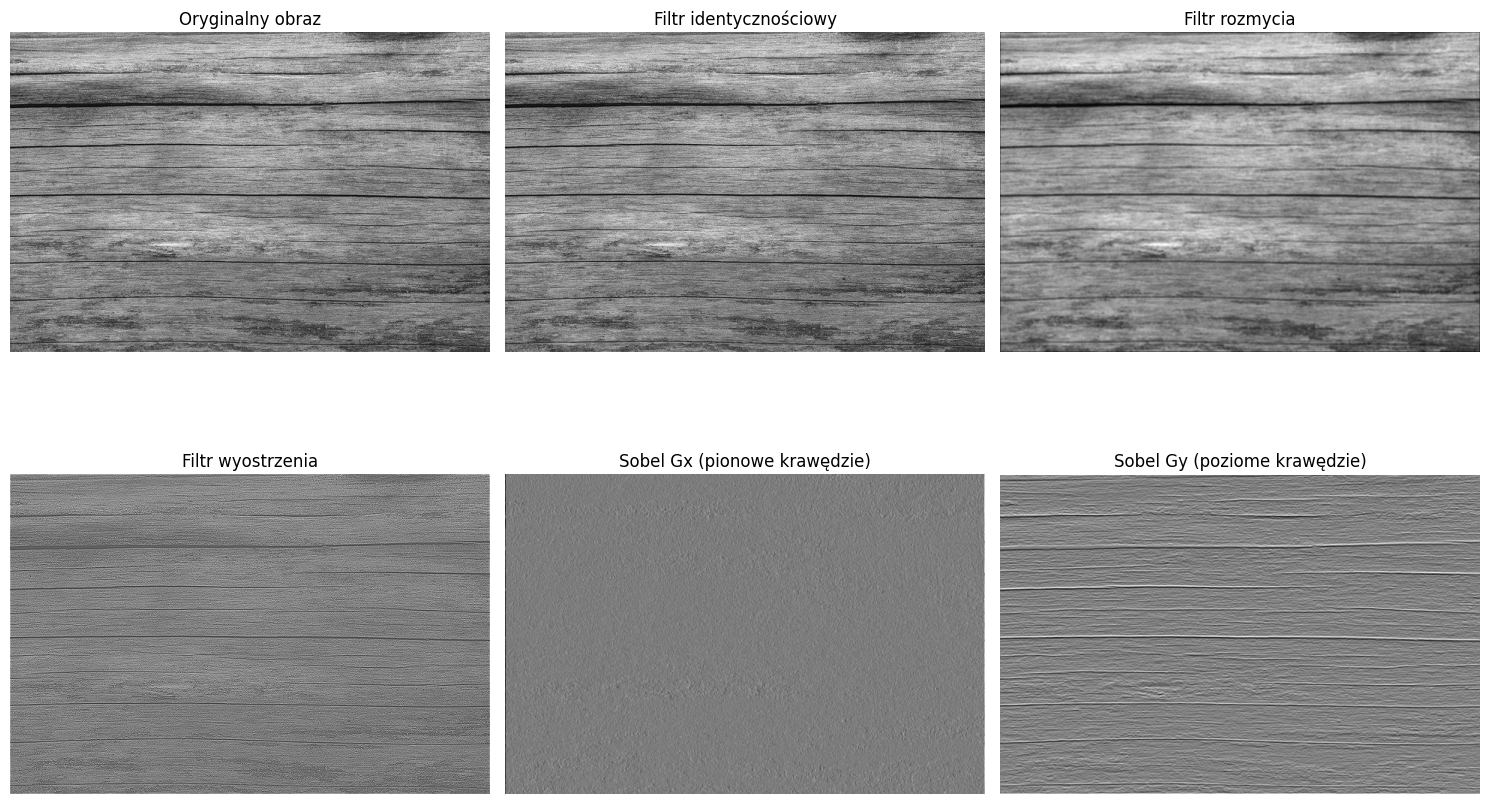

In [ ]:
# Aplikacja filtrów na obrazie
results = []
for kernel, name in filters:
    conv_layer, _ = create_conv_layer(kernel, name)
    with torch.no_grad():
        filtered = conv_layer(image_tensor)
    results.append((filtered, name))

# Wizualizacja wyników
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Oryginalny obraz
axes[0].imshow(image_tensor[0, 0].numpy(), cmap='gray')
axes[0].set_title('Oryginalny obraz')
axes[0].axis('off')

# Wyniki filtrów
for i, (result, name) in enumerate(results):
    axes[i+1].imshow(result[0, 0].numpy(), cmap='gray')
    axes[i+1].set_title(name)
    axes[i+1].axis('off')

plt.tight_layout()

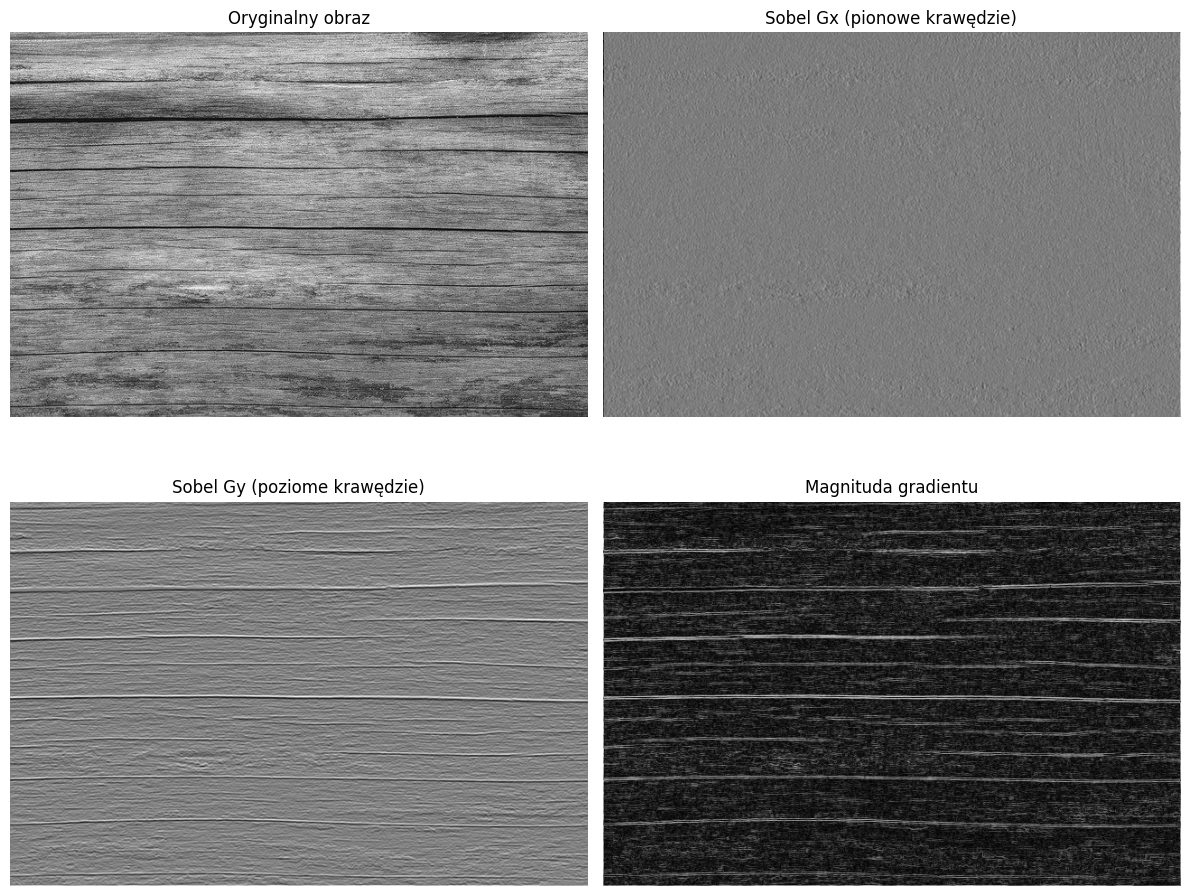

Analiza gradientu:
Gradient Gx - min: -2.973, max: 3.114
Gradient Gy - min: -2.871, max: 2.824
Magnituda - min: 0.000, max: 3.137


In [ ]:
# Analiza gradientu (kombinacja filtrów Sobel)
sobel_gx = results[3][0]  # Sobel Gx
sobel_gy = results[4][0]  # Sobel Gy

# Obliczenie magnitudy gradientu
gradient_magnitude = torch.sqrt(sobel_gx**2 + sobel_gy**2)

# Wizualizacja detekcji krawędzi
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0,0].imshow(image_tensor[0, 0].numpy(), cmap='gray')
axes[0,0].set_title('Oryginalny obraz')
axes[0,0].axis('off')

axes[0,1].imshow(sobel_gx[0, 0].numpy(), cmap='gray')
axes[0,1].set_title('Sobel Gx (pionowe krawędzie)')
axes[0,1].axis('off')

axes[1,0].imshow(sobel_gy[0, 0].numpy(), cmap='gray')
axes[1,0].set_title('Sobel Gy (poziome krawędzie)')
axes[1,0].axis('off')

axes[1,1].imshow(gradient_magnitude[0, 0].numpy(), cmap='gray')
axes[1,1].set_title('Magnituda gradientu')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

print("Analiza gradientu:")
print(f"Gradient Gx - min: {sobel_gx.min():.3f}, max: {sobel_gx.max():.3f}")
print(f"Gradient Gy - min: {sobel_gy.min():.3f}, max: {sobel_gy.max():.3f}")
print(f"Magnituda - min: {gradient_magnitude.min():.3f}, max: {gradient_magnitude.max():.3f}")

## Wpływ parametrów konwolucji

Sprawdzono jak różne parametry wpływają na wynik konwolucji.


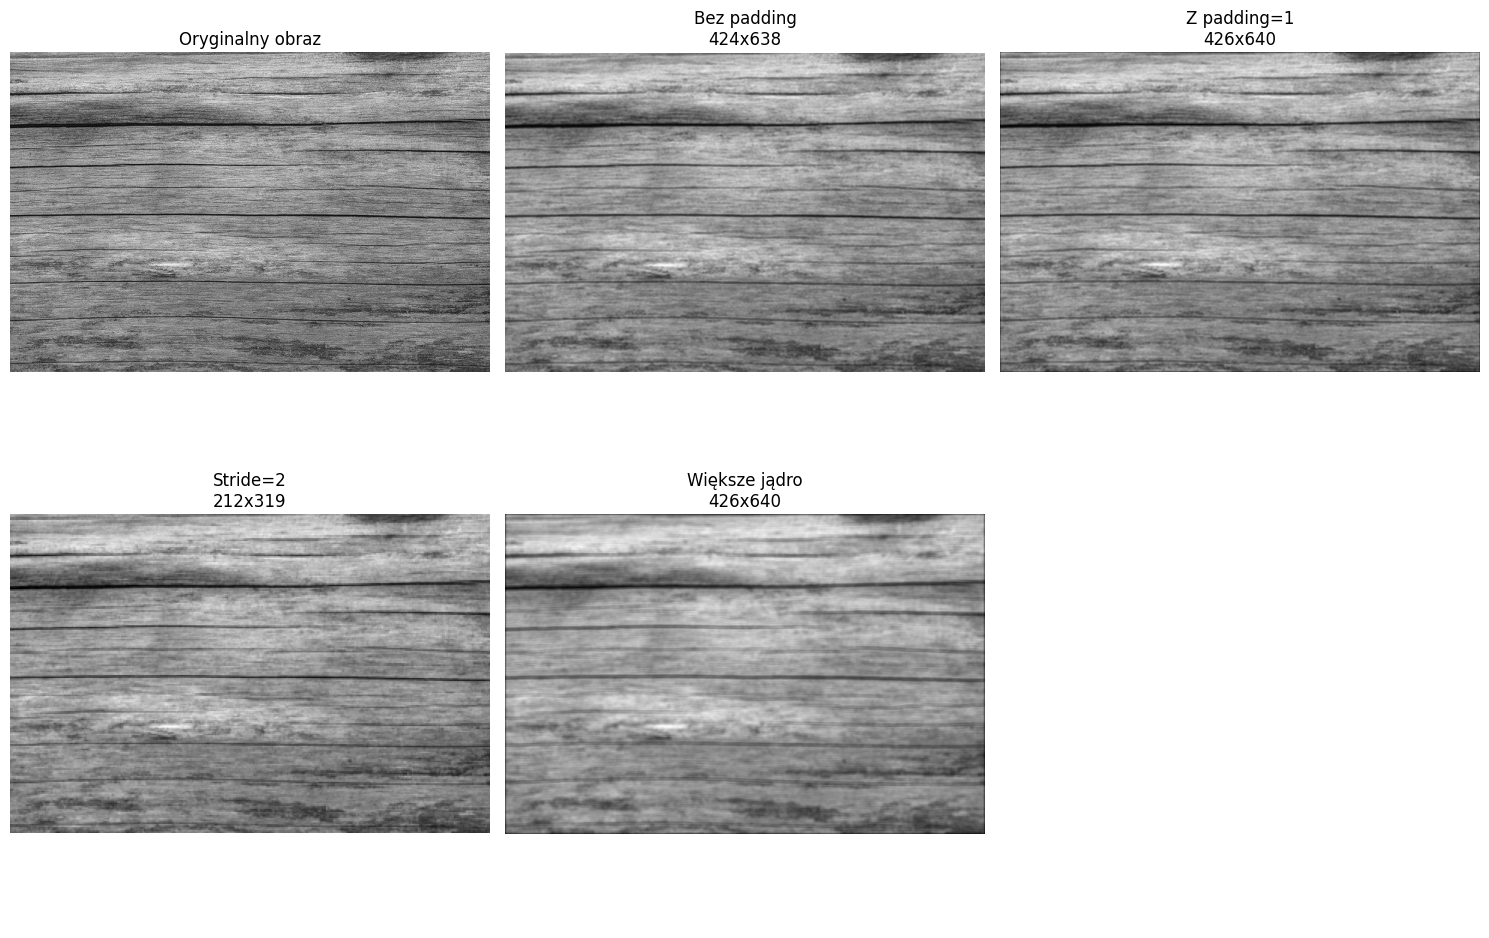

In [ ]:
# Test wpływu parametrów na rzeczywistym obrazie
configs = [
    (3, 1, 0, "Bez padding"),
    (3, 1, 1, "Z padding=1"),
    (3, 2, 0, "Stride=2"),
    (5, 1, 2, "Większe jądro")
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Oryginalny obraz
axes[0].imshow(image_tensor[0, 0].numpy(), cmap='gray')
axes[0].set_title('Oryginalny obraz')
axes[0].axis('off')

# Testy różnych konfiguracji
for i, (kernel_size, stride, padding, name) in enumerate(configs):
    conv_test = nn.Conv2d(1, 1, kernel_size, stride=stride, padding=padding)
    conv_test.weight.data = torch.ones(1, 1, kernel_size, kernel_size) / (kernel_size**2)
    conv_test.bias.data = torch.zeros(1)
    
    with torch.no_grad():
        result = conv_test(image_tensor)
    
    axes[i+1].imshow(result[0, 0].numpy(), cmap='gray')
    axes[i+1].set_title(f'{name}\n{result.shape[2]}x{result.shape[3]}')
    axes[i+1].axis('off')

# Hide the last unused subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

## Porównanie z OpenCV

Porównano wyniki konwolucji PyTorch z implementacją OpenCV.


Porównanie PyTorch vs OpenCV:
Filtr rozmycia:
  Maksymalna różnica: 0.357734
  Czy identyczne: ✗
Filtr wyostrzenia:
  Maksymalna różnica: 1.301961
  Czy identyczne: ✗


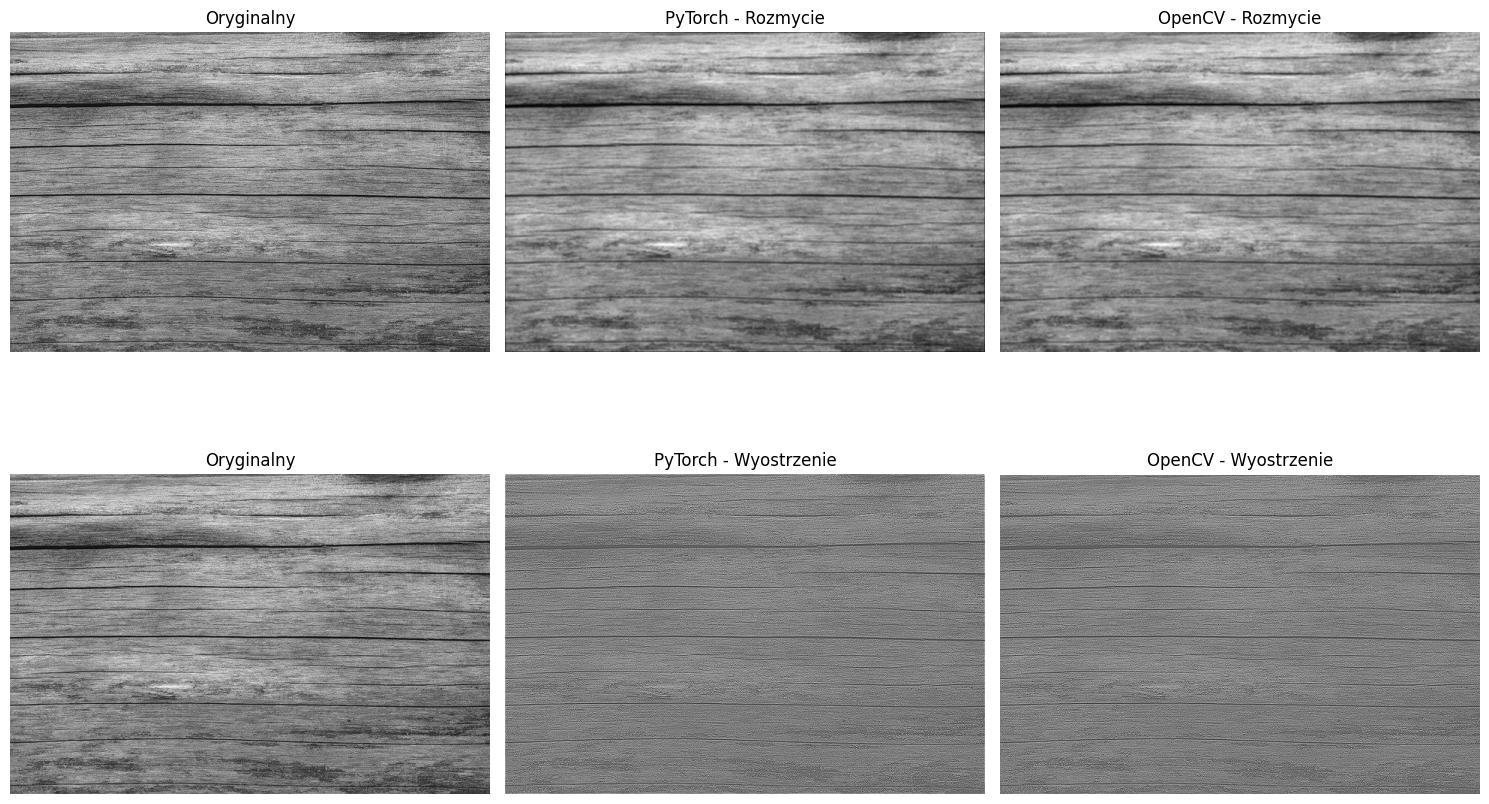

In [ ]:
# Porównanie PyTorch vs OpenCV
def compare_pytorch_opencv(image, kernel, name):
    """Porównuje wyniki konwolucji PyTorch i OpenCV"""
    
    # PyTorch
    conv_pytorch = nn.Conv2d(1, 1, kernel.shape[0], padding=1)
    conv_pytorch.weight.data = torch.tensor(kernel).float().unsqueeze(0).unsqueeze(0)
    conv_pytorch.bias.data = torch.zeros(1)
    
    with torch.no_grad():
        result_pytorch = conv_pytorch(image)
    
    # OpenCV
    kernel_cv = kernel.astype(np.float32)
    result_opencv = cv2.filter2D(image[0, 0].numpy(), -1, kernel_cv)
    
    # Porównanie
    diff = np.abs(result_pytorch[0, 0].numpy() - result_opencv)
    max_diff = np.max(diff)
    
    print(f"{name}:")
    print(f"  Maksymalna różnica: {max_diff:.6f}")
    print(f"  Czy identyczne: {'✓' if max_diff < 1e-5 else '✗'}")
    
    return result_pytorch, result_opencv

# Test porównania
print("Porównanie PyTorch vs OpenCV:")
print("=" * 50)

# Test z filtrem rozmycia
blur_kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]) / 9
pytorch_blur, opencv_blur = compare_pytorch_opencv(image_tensor, blur_kernel, "Filtr rozmycia")

# Test z filtrem wyostrzenia  
sharp_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
pytorch_sharp, opencv_sharp = compare_pytorch_opencv(image_tensor, sharp_kernel, "Filtr wyostrzenia")

# Wizualizacja porównania
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0,0].imshow(image_tensor[0, 0].numpy(), cmap='gray')
axes[0,0].set_title('Oryginalny')
axes[0,0].axis('off')

axes[0,1].imshow(pytorch_blur[0, 0].numpy(), cmap='gray')
axes[0,1].set_title('PyTorch - Rozmycie')
axes[0,1].axis('off')

axes[0,2].imshow(opencv_blur, cmap='gray')
axes[0,2].set_title('OpenCV - Rozmycie')
axes[0,2].axis('off')

axes[1,0].imshow(image_tensor[0, 0].numpy(), cmap='gray')
axes[1,0].set_title('Oryginalny')
axes[1,0].axis('off')

axes[1,1].imshow(pytorch_sharp[0, 0].numpy(), cmap='gray')
axes[1,1].set_title('PyTorch - Wyostrzenie')
axes[1,1].axis('off')

axes[1,2].imshow(opencv_sharp, cmap='gray')
axes[1,2].set_title('OpenCV - Wyostrzenie')
axes[1,2].axis('off')

plt.tight_layout()

## Podsumowanie

### Wyniki:
- **Filtry konwolucyjne** skutecznie wykrywają krawędzie (Sobel) i wyostrzają obrazy
- **Parametry stride i padding** znacząco wpływają na rozmiar wyjścia
- **Padding** zachowuje rozmiar obrazu, **stride** go zmniejsza

### Wnioski:
- Konwolucja jest podstawową operacją w przetwarzaniu obrazów
- Różne filtry mają różne zastosowania (rozmycie, wyostrzenie, detekcja krawędzi)
- Parametry konwolucji muszą być dobrane odpowiednio do zadania